In [30]:
import tensorflow as tf
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
# fetching data
!gdown --id 1UFkF9wWkJIS2BvnhCcfLgEbrkh2L3r4j

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1UFkF9wWkJIS2BvnhCcfLgEbrkh2L3r4j
To: /content/animal_image.zip
100% 30.3M/30.3M [00:00<00:00, 165MB/s]


In [32]:
!unzip /content/animal_image.zip

Archive:  /content/animal_image.zip
replace animal_image/test/animal chicken/0U5DJ4AHL7U8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: animal_image/test/animal chicken/0U5DJ4AHL7U8.jpg  
  inflating: animal_image/test/animal chicken/0YRRH5UO983S.jpg  
  inflating: animal_image/test/animal chicken/17ZH2WHTIPL8.jpg  
  inflating: animal_image/test/animal chicken/1O9LZD4GDLEG.jpg  
  inflating: animal_image/test/animal chicken/1OX6JD87ZL6M.jpg  
  inflating: animal_image/test/animal chicken/1WHCYYP4QBBB.jpg  
  inflating: animal_image/test/animal chicken/1ZLB7IELNMCD.jpg  
  inflating: animal_image/test/animal chicken/21AEDSI4YQ9L.jpg  
  inflating: animal_image/test/animal chicken/2GGVG9VUE5VP.jpg  
  inflating: animal_image/test/animal chicken/2IH2F7SXSTFS.jpg  
  inflating: animal_image/test/animal chicken/2MD30734HGEK.jpg  
  inflating: animal_image/test/animal chicken/30XSIDP797YK.jpg  
  inflating: animal_image/test/animal chicken/37ROYA9ANCBW.jpg  
  inflating: animal_

In [33]:
# Path to test directory
test_data_dir = "/content/animal_image/test"
# Path to train directory
train_data_dir = "/content/animal_image/train"
# Path to validation directory
val_data_dir = "/content/animal_image/val"

['animal chicken', 'animal duck']


<Axes: >

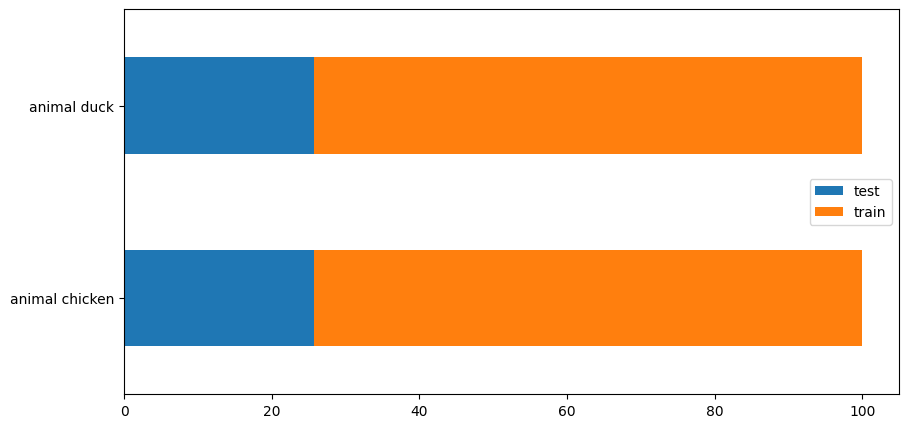

In [34]:
# Access all animal class names present for training and testing
class_names = os.listdir(train_data_dir)

animal_values = []
test_values = []
train_values = []

print(class_names)

for name in class_names:
    test_subdirectory_path = os.path.join(test_data_dir, name)
    train_subdirectory_path = os.path.join(train_data_dir, name)
    test_image_count, train_image_count = len(os.listdir(test_subdirectory_path)), len(
        os.listdir(train_subdirectory_path)
    )
    total_image_count = train_image_count + test_image_count
    test_percent = round((test_image_count / total_image_count) * 100, 2)
    train_percent = round((train_image_count / total_image_count) * 100, 2)

    # Update the lists with appropriate values
    animal_values.append(name)
    test_values.append(test_percent)
    train_values.append(train_percent)

# Create a Pandas Dataframe
df = pd.DataFrame({"test": test_values, "train": train_values}, index=animal_values)

# Plot the data
df.plot(
    kind="barh",
    stacked=True,
    figsize=(10,5),
)

In [35]:
batch_size = 32
img_height = 256
img_width = 256

train_image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, shear_range=0.2, zoom_range=0.2)

test_image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, shear_range=0.2, zoom_range=0.2)

val_image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, shear_range=0.2, zoom_range=0.2)

train_datagen = train_image_data_generator.flow_from_directory(
    train_data_dir, batch_size=batch_size, class_mode="categorical", target_size=(img_width, img_height))

test_datagen = test_image_data_generator.flow_from_directory(
    test_data_dir, batch_size=batch_size, class_mode="categorical", target_size=(img_width, img_height))

val_datagen = val_image_data_generator.flow_from_directory(
    val_data_dir, batch_size=batch_size, class_mode="categorical", target_size=(img_width, img_height))

Found 664 images belonging to 2 classes.
Found 230 images belonging to 2 classes.
Found 104 images belonging to 2 classes.


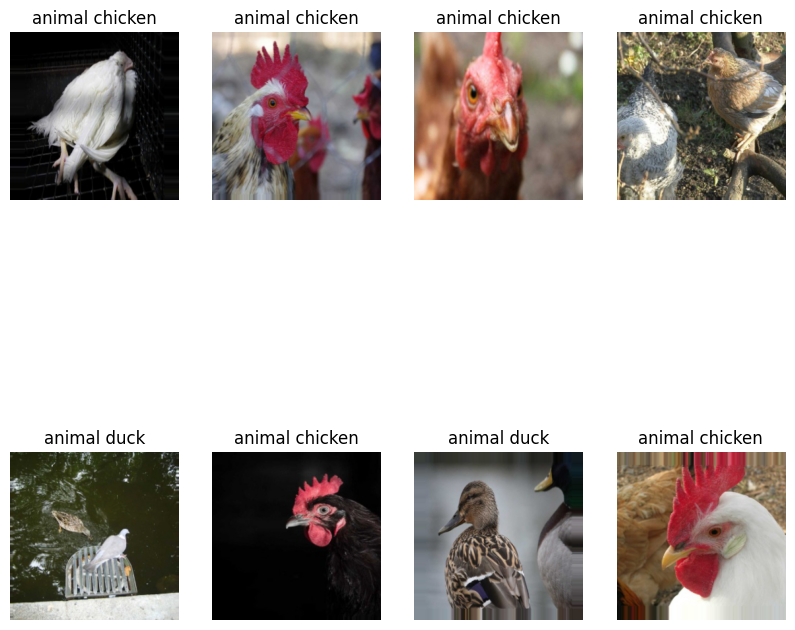

In [36]:
import numpy as np
plt.figure(figsize=(10,10))
batch,p = train_datagen.next()
for i in range(1,9):
   plt.subplot(2,4,i)
   
   image = batch[i]
   plt.imshow(image)

   plt.title(class_names[np.argmax(p[i])])
   plt.axis('off')
plt.show()

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16,decode_predictions

In [38]:
#We are using a VGG-16 model with "imagenet" weights
model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(256,256,3))

In [39]:
#These layers will not be trained
for layers in model.layers:
  layers.trainable=False


#Taking the last layer of the VGG-16 layer
last_output = model.output


#Adding a Flatten layer
vgg_x = Flatten()(last_output)


#Adding a Dense layer for linear output
vgg_x = Dense(128, activation = 'relu')(vgg_x)


#The output layer will give 6 values, a probability distribution for each label
vgg_x = Dense(2, activation = 'softmax')(vgg_x)


#Connecting the linear layers to the VGG-16 model
vgg16_final_model = Model(model.input, vgg_x)


#Compiling the model
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [40]:
vgg16_final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [41]:
#Fitting the model
epochs = 20
history = vgg16_final_model.fit(train_datagen,steps_per_epoch=len(train_datagen),
                      epochs=epochs,validation_data=val_datagen,validation_steps=len(val_datagen))

Epoch 1/20
21/21 [==============================] - 16s 640ms/step - loss: 0.6769 - accuracy: 0.5723 - val_loss: 0.6355 - val_accuracy: 0.6058
Epoch 2/20
21/21 [==============================] - 13s 634ms/step - loss: 0.5466 - accuracy: 0.7530 - val_loss: 0.5517 - val_accuracy: 0.6731
Epoch 3/20
21/21 [==============================] - 13s 612ms/step - loss: 0.4784 - accuracy: 0.8042 - val_loss: 0.5034 - val_accuracy: 0.7692
Epoch 4/20
21/21 [==============================] - 13s 629ms/step - loss: 0.4382 - accuracy: 0.8193 - val_loss: 0.4666 - val_accuracy: 0.7308
Epoch 5/20
21/21 [==============================] - 13s 622ms/step - loss: 0.3900 - accuracy: 0.8434 - val_loss: 0.4327 - val_accuracy: 0.7885
Epoch 6/20
21/21 [==============================] - 13s 616ms/step - loss: 0.3706 - accuracy: 0.8479 - val_loss: 0.4548 - val_accuracy: 0.7308
Epoch 7/20
21/21 [==============================] - 13s 610ms/step - loss: 0.3549 - accuracy: 0.8494 - val_loss: 0.3754 - val_accuracy: 0.8077

In [42]:
epochs_range = range(epochs)

training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a pd Dataframe for accuracy
acc_df = pd.DataFrame({"Training Accuracy":training_acc, "Validation Accuracy":validation_acc}, index=epochs_range)
# Create a pd Dataframe for loss
loss_df = pd.DataFrame({"Training Loss":training_loss, "Validation Loss":validation_loss}, index=epochs_range)

In [43]:
# Save the entire model (architecture, weights, and optimizer state) 
vgg16_final_model.save("animal_detection_model")
# Save only the weights of the model
vgg16_final_model.save_weights("animal_detection_model_weights.h5")

In [44]:
#Loading the model
from keras.models import load_model
Model = load_model('animal_detection_model')

In [45]:
true_classes = test_datagen.classes
class_indices = train_datagen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = Model.predict(test_datagen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)


8/8 [==============================] - 5s 593ms/step


In [87]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy: 84.07%


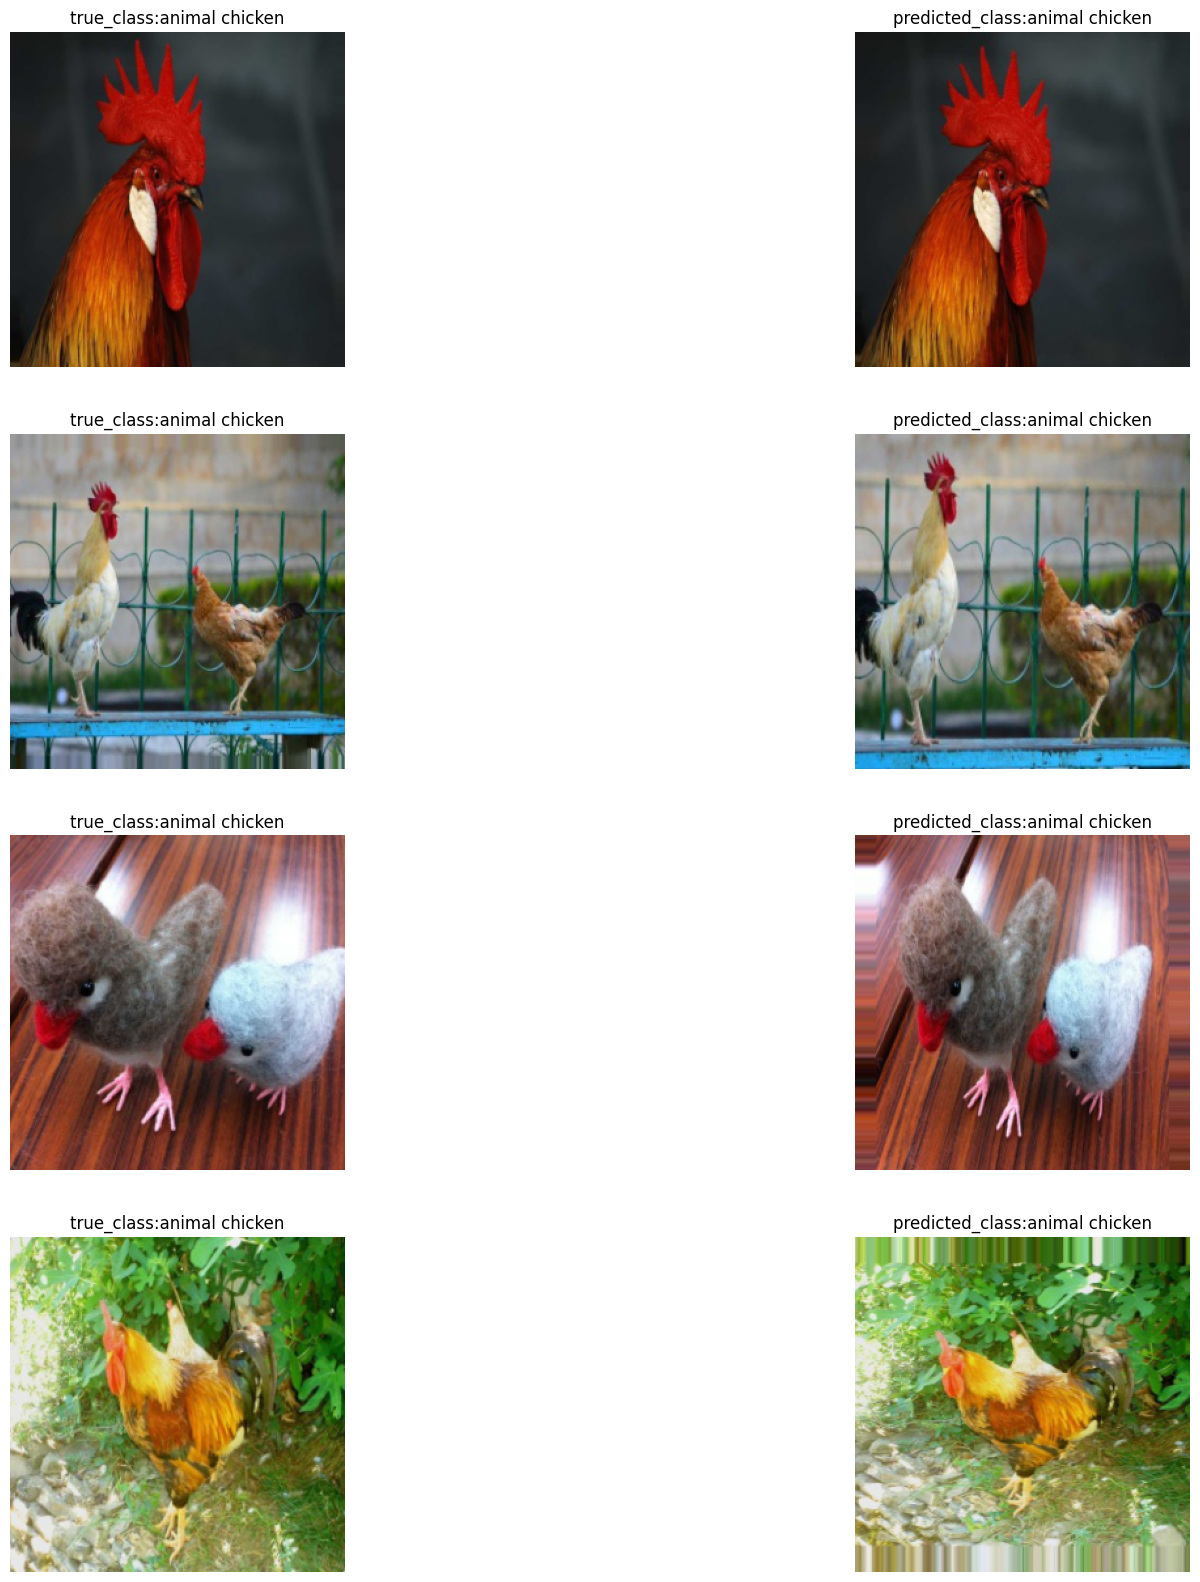

In [78]:
import numpy as np
plt.figure(figsize=(20,20))
l = [0,3,5,9]
c = 1
for i in range(len(l)):
   plt.subplot(4,2,c)
   image = test_datagen[0][0][l[i]]
   plt.imshow(image)
   plt.title(f'true_class:{class_names[np.argmax(test_datagen[0][1][l[i]])]}')
   plt.axis('off')
   
   c += 1
   plt.subplot(4,2,c)
   image = test_datagen[0][0][l[i]]
   plt.imshow(image)
   plt.title(f'predicted_class:{class_names[np.argmax(vgg_preds[0*32+l[i]])]}')
   plt.axis('off')
   c += 1

plt.show()

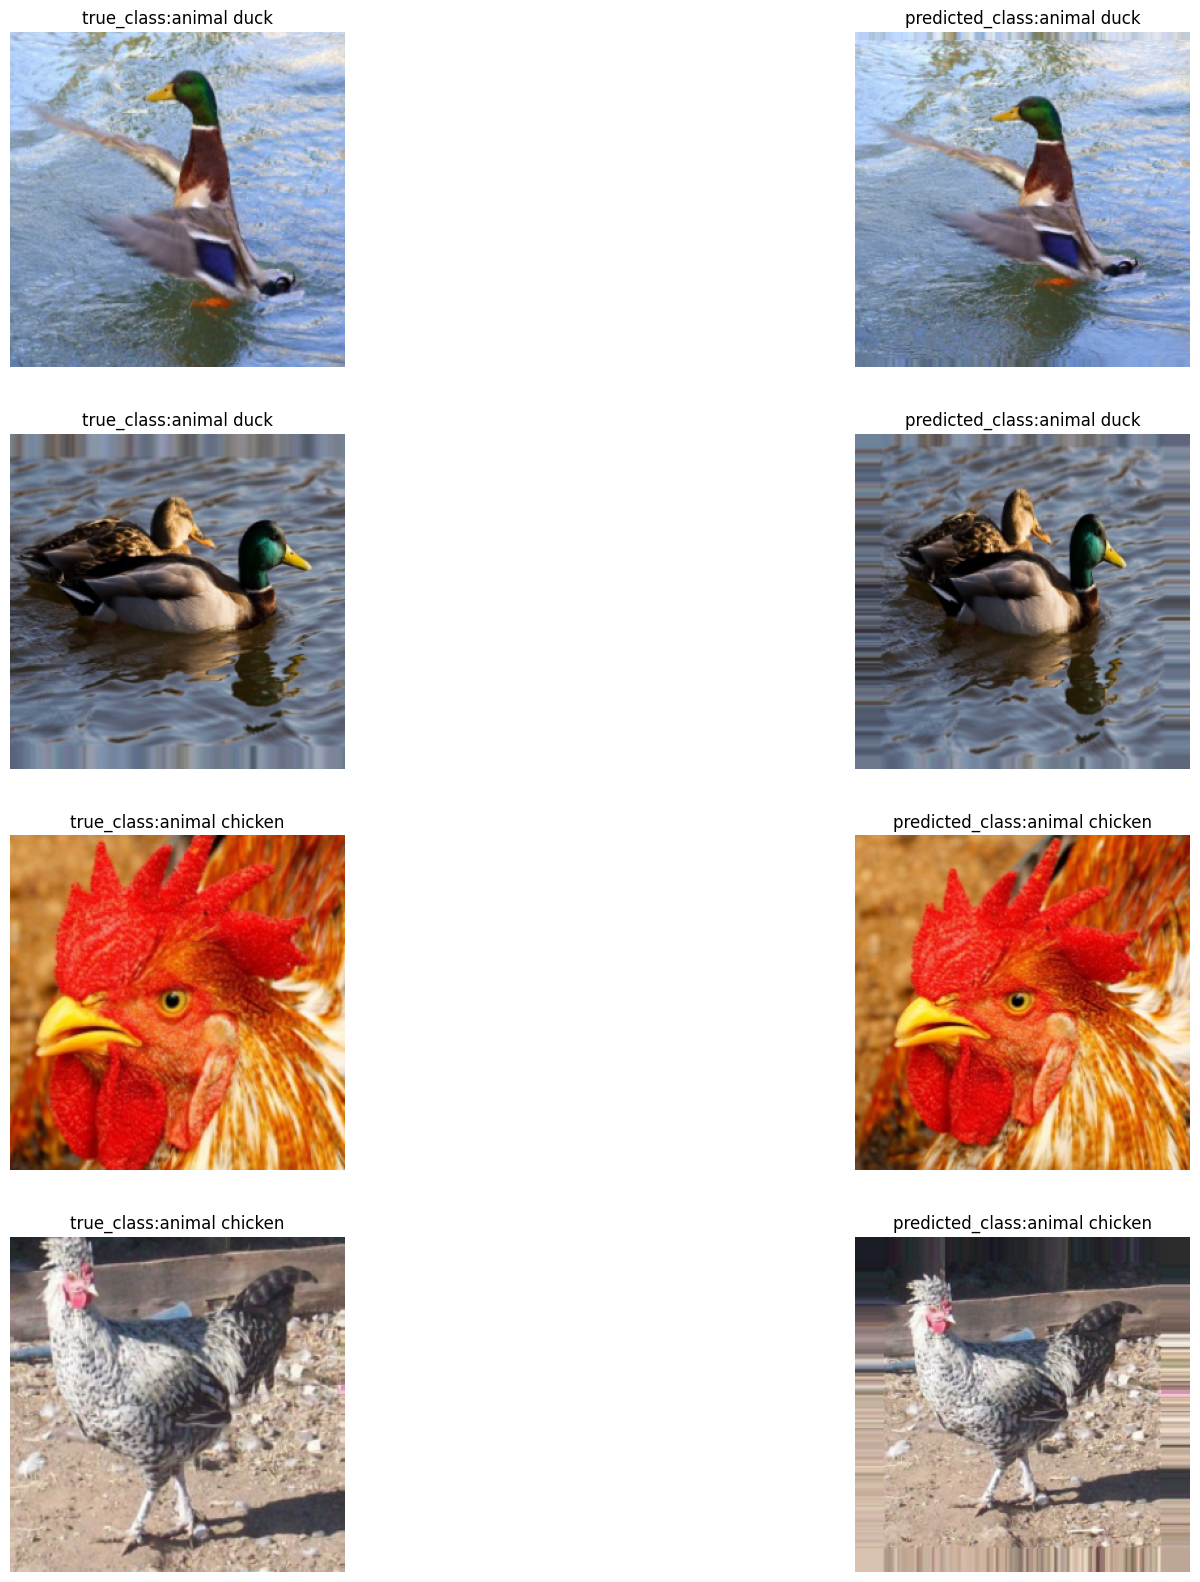

In [86]:
import numpy as np
plt.figure(figsize=(20,20))
l = [7,11,12,15]
c = 1
for i in range(len(l)):
   plt.subplot(4,2,c)
   image = test_datagen[5][0][l[i]]
   plt.imshow(image)
   plt.title(f'true_class:{class_names[np.argmax(test_datagen[5][1][l[i]])]}')
   plt.axis('off')
   
   c += 1
   plt.subplot(4,2,c)
   image = test_datagen[5][0][l[i]]
   plt.imshow(image)
   plt.title(f'predicted_class:{class_names[np.argmax(vgg_preds[5*32+l[i]])]}')
   plt.axis('off')
   c += 1

plt.show()